In [73]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np


In [74]:
# https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
def read_folder_csv(path):
    all_files = glob.glob(os.path.join(path, "*.csv"))
    li = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

## WASM vs JS


In [75]:
def optimization_graph(df, y_axis, y_label, max_triples=-1, small=False):
    # x = df['triples']
    k_values = sorted(df['k'].unique())

    if max_triples != -1:
        df = df[df['triples'] <= max_triples]

    for k in k_values:
        def plot(mode, color=None, linestyle=None):
            df2 = df[(df['k'] == k) & (df['mode'] == mode)]
            df2 = df2.sort_values('triples')
            x = df2['triples']
            y = df2[y_axis]

            return plt.plot(x, y, label = f'k = {k}, {mode}',
                            linestyle=linestyle, color=color)[-1]

        p1 = plot('js')
        p2 = plot('wasm', p1.get_color(), 'dashed')

    if not small:
        plt.gcf().set_size_inches(10, 6)
    else:
        plt.gcf().set_size_inches(5, 4)
    ax = plt.gca()
    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.yscale('log')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.xlabel("Triple patterns in query", fontsize=12)
    plt.ylabel(y_label, fontsize=12)

    plt.show()


### Speed comparison


In [76]:
speed_comp = read_folder_csv('data/optimization/speed')
speed_comp.head()

,triples,k,mode,optimization_time
0,2,2,js,0.022450
1,3,2,js,0.044783
2,4,2,js,0.059933
3,5,2,js,0.085550
4,6,2,js,0.119067


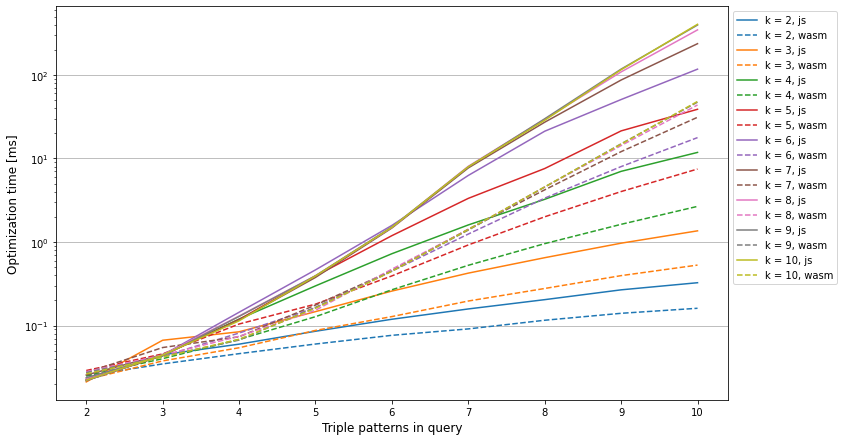

In [77]:
optimization_graph(speed_comp, 'optimization_time', 'Optimization time [ms]', 10)


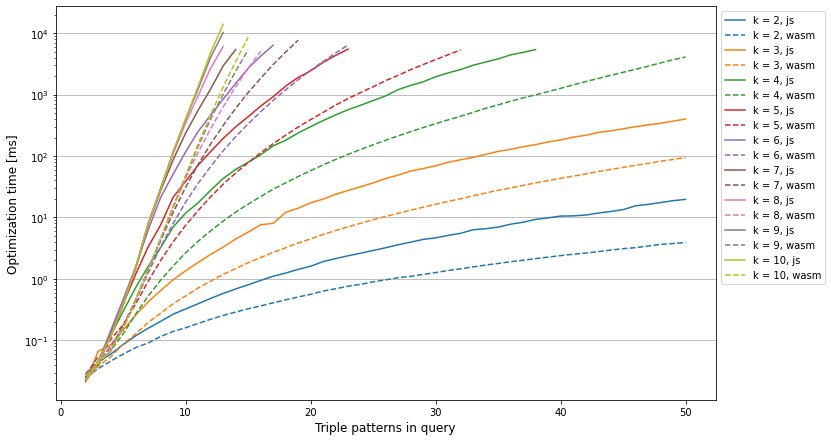

In [78]:
optimization_graph(speed_comp, 'optimization_time', 'Optimization time [ms]')

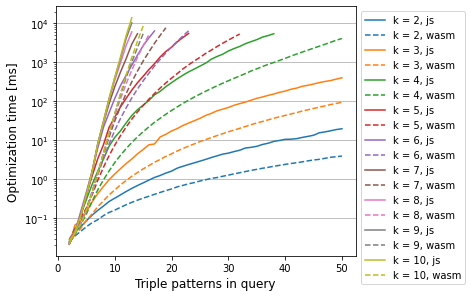

In [79]:
optimization_graph(speed_comp, 'optimization_time', 'Optimization time [ms]', small=True)


In [80]:
# def optimization_speed_ratio_plot(df):
#
#     df_js_times = df[(df['mode'] == 'js') & (df['optimization_time'] < 1000)]
#
#     xy_pairs = []
#
#     for index, row in df_js_times.iterrows():
#         k = row['k']
#         triples = row['triples']
#         old_time = row['optimization_time']
#
#         wasm_row = df[(df['mode'] == 'wasm') & (df['k'] == k) & (df['triples'] == triples)]
#         wasm_row = wasm_row.iloc[0]
#         new_time = wasm_row['optimization_time']
#         ratio = old_time / new_time
#
#         xy_pairs.append((old_time, ratio*100))
#
#     xy_pairs = sorted(xy_pairs, key=lambda x: x[0])
#
#     x = [t[0] for t in xy_pairs]
#     y = [t[1] for t in xy_pairs]
#     # poly = np.polyfit(x,y,3)
#     # y = np.poly1d(poly)(x)
#
#     plt.plot(x, y)
#     plt.xlabel("Optimization time in JS", fontsize=12)
#     plt.ylabel("Speed increase in WASM (%)", fontsize=12)
#
#     plt.show()

def optimization_ratio_plot(df, xlabel, ylabel, column, logx=True, logy=False, small=False):
    # x = df['triples']
    k_values = sorted(df['k'].unique())

    for k in k_values:
        df2 = df[(df['k'] == k) & (df['mode'] == 'js')]
        xy_pairs = []
        for index, row in df2.iterrows():
            k = row['k']
            triples = row['triples']
            old_val = row[column]

            wasm_row = df[(df['mode'] == 'wasm') & (df['k'] == k) & (df['triples'] == triples)]
            wasm_row = wasm_row.iloc[0]
            new_val = wasm_row[column]
            ratio = old_val / new_val

            xy_pairs.append((old_val, ratio))

        x = [t[0] for t in xy_pairs]
        y = [t[1] for t in xy_pairs]

        plt.plot(x, y, label = f'k = {k}')

    if not small:
        plt.gcf().set_size_inches(10, 6)
    else:
        plt.gcf().set_size_inches(5, 4)
    if logy:
      plt.yscale('log')
    ax = plt.gca()
    ax.yaxis.grid(True, which='both')
    if logx:
      plt.xscale('log')
    plt.tight_layout()
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    plt.show()



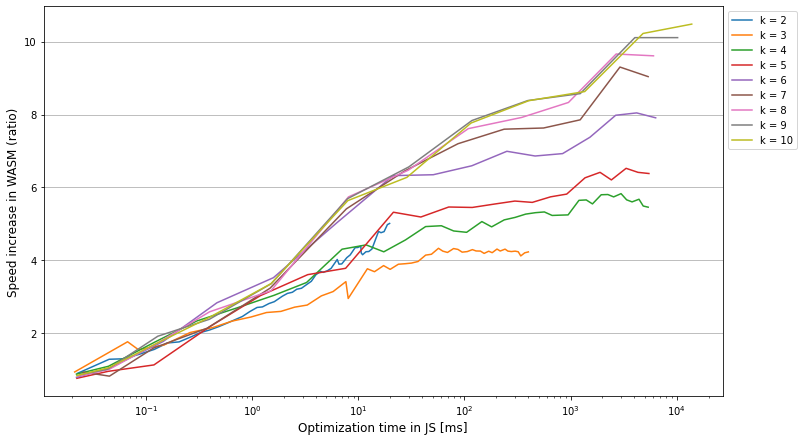

In [81]:
optimization_ratio_plot(
    speed_comp,
    "Optimization time in JS [ms]",
    "Speed increase in WASM (ratio)",
    "optimization_time"
)

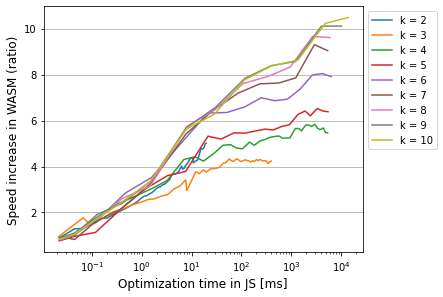

In [82]:
optimization_ratio_plot(
    speed_comp,
    "Optimization time in JS [ms]",
    "Speed increase in WASM (ratio)",
    "optimization_time",
    small=True
)

Instantiating WebAssembly overhead:

| startup time |
|---|
22.722 (first evaluation - average across 5 runs)
9.574
4.641
0.664
5.139
0.693
4.729
4.87
1.464
2.703
1.912
1.169
3.951
0.695
4.017
0.689
2.163
0.787
3.249
0.674

Instantiating WASM took 3.82ms average

The instantiation for the first engine took 22.7ms

Only done once per engine creation, cost is neglected in further measurements (because of the warmup)



### Memory comparison

wasm needs 6MB initial memory


In [83]:
memory_comp = read_folder_csv('data/optimization/memory')
memory_comp.head()

,triples,k,mode,memory_usage
0,2,2,wasm,65.536
1,3,2,wasm,65.536
2,4,2,wasm,65.536
3,5,2,wasm,65.536
4,6,2,wasm,65.536


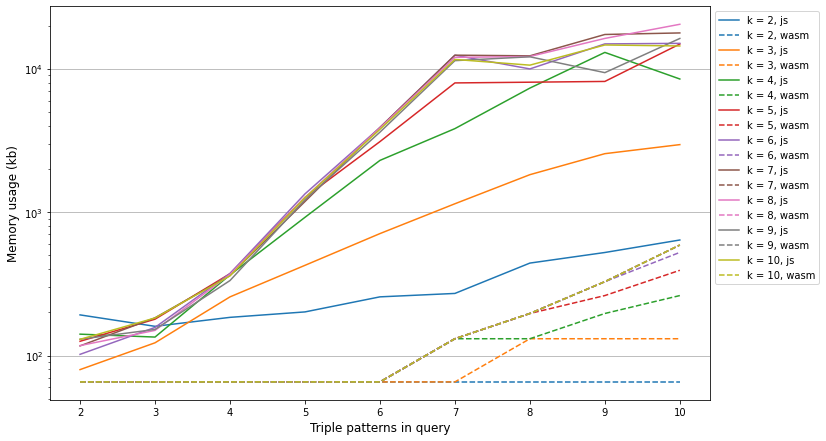

In [84]:
optimization_graph(memory_comp, 'memory_usage', 'Memory usage (kb)', 10)


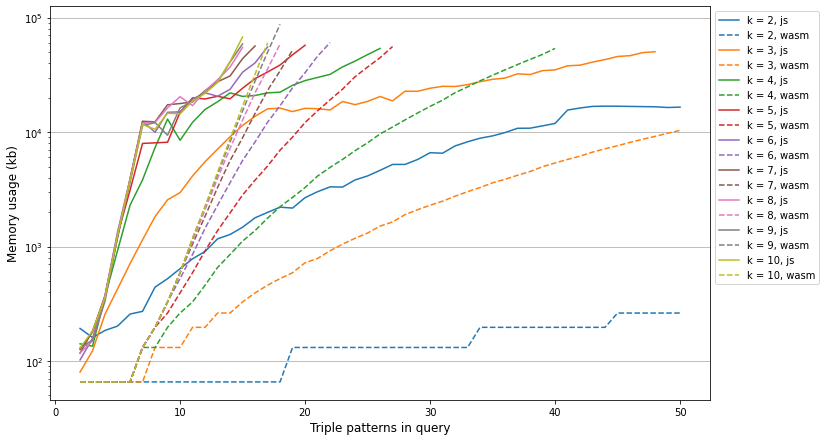

In [85]:
optimization_graph(memory_comp, 'memory_usage', 'Memory usage (kb)')

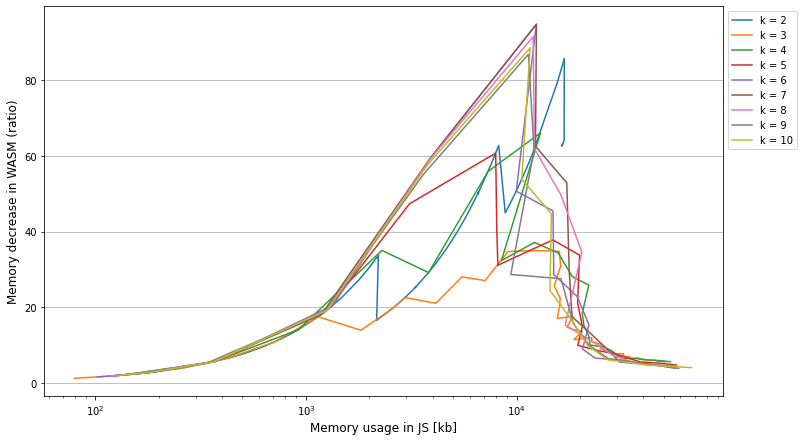

In [86]:
optimization_ratio_plot(
    memory_comp,
    "Memory usage in JS [kb]",
    "Memory decrease in WASM (ratio)",
    "memory_usage"
)

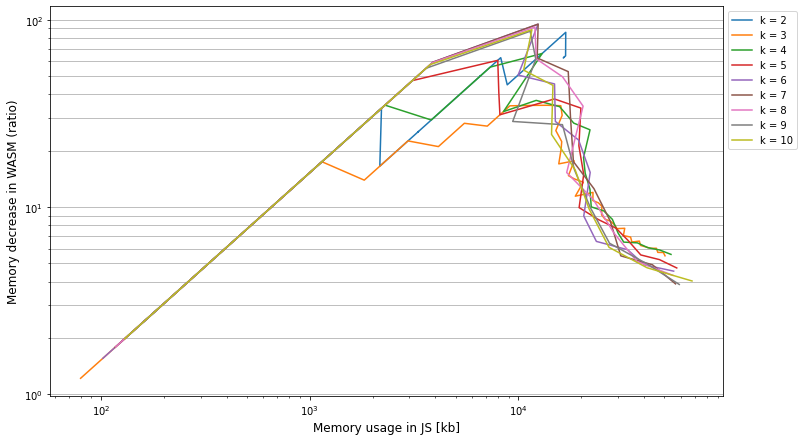

In [87]:

optimization_ratio_plot(
    memory_comp,
    "Memory usage in JS [kb]",
    "Memory decrease in WASM (ratio)",
    "memory_usage",
    logy=True
)

# explanation; garbage collection

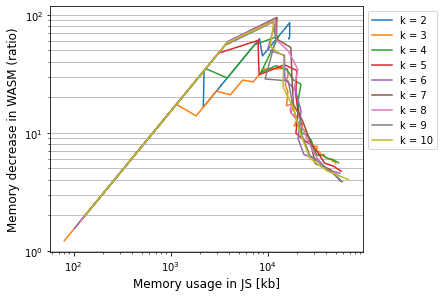

In [88]:

optimization_ratio_plot(
    memory_comp,
    "Memory usage in JS [kb]",
    "Memory decrease in WASM (ratio)",
    "memory_usage",
    logy=True,
    small=True
)

## Crop evaluation

### Server.js - k comparison


In [89]:
# for each query, find the best value for k, and compare
# the other query evaluations against the best value.
def k_comparison(df):

    df = df.copy()

    # k values are calculated up until the size of the triple patterns
    # in the query, but using a higher value for k is possible too, and
    # is automatically reduced to the size of the triple patterns.
    # we need to fill these values by duplicating the biggest value for k up to k=10

    df_highest_ks = df[df['k'] == df['triples']]

    for index, row in df_highest_ks.iterrows():
        for k in range(row['k']+1, 11):
            new_row = row.copy()
            new_row['k'] = k
            new_df = pd.DataFrame([new_row])
            df = pd.concat([df, new_df], axis=0, ignore_index=True)
            # df = df.append(new_row, ignore_index=True)

    def best_k_time(row):
        # returns the time of the best k for this query
        set = row['set']
        id = row['id']

        df_query = df[(df['set'] == set) & (df['id'] == id)]
        return df_query['totalTime'].min()

    df['best_k_time'] = df.apply(best_k_time, axis=1)

    def time_ratio(row):
        return row['totalTime'] / row['best_k_time']

    df['k_comparison'] = df.apply(time_ratio, axis=1)

    k_values = df['k'].unique()
    k_values = filter(lambda val: val != -1, k_values)
    k_data = {'k': k_values}

    k_scores = pd.DataFrame(k_data)

    def mean_k_score(row):
        df_k = df[df['k'] == row['k']]
        return df_k['k_comparison'].mean()

    def median_k_score(row):
        df_k = df[df['k'] == row['k']]
        return df_k['k_comparison'].median()

    k_scores['mean'] = df.apply(mean_k_score, axis=1)
    k_scores['median'] = df.apply(median_k_score, axis=1)
    return k_scores, df


def box_plot_k_comparison(df, ignore=None):
    ignore = set() if ignore is None else set(ignore)

    k_scores, df = k_comparison(df)

    k_values = list(k_scores['k'])
    k_values = list(filter(lambda x: x not in ignore, k_values))
    data = []
    for k in k_values:
        df_k = df[df['k'] == k]
        data.append(list(df_k['k_comparison']))

    # plt.boxplot(data, showfliers=False, showmeans=True, meanprops={
    #     "marker":"s",
    #     "markerfacecolor":"white",
    #     "markeredgecolor":"blue"
    # })
    plt.boxplot(data, showfliers=False, showmeans=True)
    plt.xticks(list(range(1, len(k_values) + 1)), k_values)

    plt.xlabel("Block size $k$", fontsize=12)
    plt.ylabel("Execution time / best time", fontsize=12)


# path = "./data/100k/ldf-server/different-k-comparison"
# data_100k_diff_k = read_folder_csv(path)
# k_scores100k, data_100k_diff_k = k_comparison(data_100k_diff_k)

#### 100k dataset

In [90]:
path = "./data/100k/ldf-server/different-k-comparison"

data_100k_diff_k = read_folder_csv(path)

data_100k_diff_k.head()


,engine,set,dataset,k,id,triples,results,calcTime,execTime,totalTime,error,timestamps
0,crop-wasm-2,C2,100k,2,0,10,0,0.3283,383.2053,383.5336,NaN,NaN
1,crop-wasm-3,C2,100k,3,0,10,0,0.7607,378.9299,379.6906,NaN,NaN
2,crop-wasm-4,C2,100k,4,0,10,0,1.2155,741.7870,743.0025,NaN,NaN
3,crop-wasm-5,C2,100k,5,0,10,0,2.0221,3691.3305,3693.3526,NaN,NaN
4,crop-wasm-6,C2,100k,6,0,10,0,4.0318,1483.8778,1487.9096,NaN,NaN


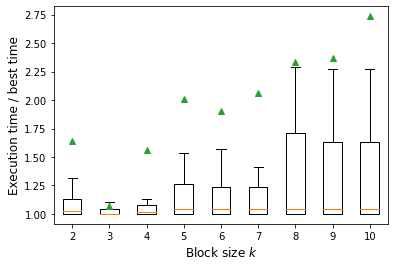

In [91]:
# box_plot_k_comparison(data_100k_diff_k, [10, 8, 9])
box_plot_k_comparison(data_100k_diff_k)

In [92]:
k_scores100k, data_100k_diff_k = k_comparison(data_100k_diff_k)
k_scores100k

# best k = 3!

,k,mean,median
0,2,1.639373,1.023403
1,3,1.069212,1.000000
2,4,1.557190,1.013107
3,5,2.006404,1.039916
4,6,1.907145,1.041157
5,7,2.059655,1.041157
6,8,2.330269,1.041157
7,9,2.368560,1.041157
8,10,2.735767,1.041157


#### 1M dataset


In [93]:
path = "./data/1M/ldf-server/different-k-comparison"
data_1M_diff_k = read_folder_csv(path)


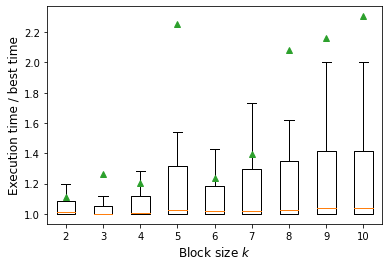

In [94]:
box_plot_k_comparison(data_1M_diff_k)


In [95]:
k_scores1M, data_1M_diff_k = k_comparison(data_1M_diff_k)
k_scores1M


,k,mean,median
0,2,1.110746,1.013304
1,3,1.265018,1.000672
2,4,1.207422,1.005585
3,5,2.255435,1.023937
4,6,1.235178,1.021321
5,7,1.393082,1.021825
6,8,2.083126,1.026049
7,9,2.160530,1.038182
8,10,2.305419,1.038182


#### 10M dataset


In [96]:
path = "./data/10M/ldf-server/different-k-comparison"
data_10M_diff_k = read_folder_csv(path)


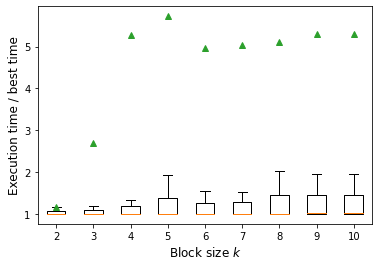

In [97]:
box_plot_k_comparison(data_10M_diff_k)


In [98]:
k_scores10M, data_10M_diff_k = k_comparison(data_10M_diff_k)
k_scores10M

,k,mean,median
0,2,1.176598,1.008476
1,3,2.691670,1.002560
2,4,5.282886,1.004972
3,5,5.723106,1.006385
4,6,4.962142,1.006385
5,7,5.036028,1.006659
6,8,5.112034,1.006659
7,9,5.296700,1.014412
8,10,5.296700,1.014412


In [99]:
def printForLatex(df):
    columns = df.columns.values.tolist()

    print('\\toprule')
    print(' & '.join([f'\\textbf{{{col}}}' for col in columns]) + '\\\\')
    print('\\midrule')

    for index, row in df.iterrows():
                print(' & '.join([ f'{row[col]}' for col in columns]) + '\\\\')

        # print(' & '.join([
        #     (f'{row[col]:.4f}').rstrip('0').rstrip('.')
        #     if isinstance(row[col], float)
        #     else row[col]
        #     for col in columns]) + '\\\\')

    print('\\bottomrule')


In [100]:
# printForLatex(k_scores100k)
# print()
# printForLatex(k_scores1M)
# print()
# printForLatex(k_scores10M)


### No server.js (file hosted) - k comparison


#### 100k dataset

In [101]:
path = "./data/100k/no-server/different-k-comparison"

data_100k_diff_k2 = read_folder_csv(path)

data_100k_diff_k2.head()


,engine,set,dataset,k,id,triples,results,calcTime,execTime,totalTime,error,timestamps
0,crop-wasm-2,C2,100k,2,0,10,0,0.2956,70.0502,70.3458,NaN,NaN
1,crop-wasm-3,C2,100k,3,0,10,0,0.4709,79.7169,80.1878,NaN,NaN
2,crop-wasm-4,C2,100k,4,0,10,0,1.0336,104.9887,106.0223,NaN,NaN
3,crop-wasm-5,C2,100k,5,0,10,0,1.9806,341.9713,343.9519,NaN,NaN
4,crop-wasm-6,C2,100k,6,0,10,0,3.7565,278.1723,281.9288,NaN,NaN


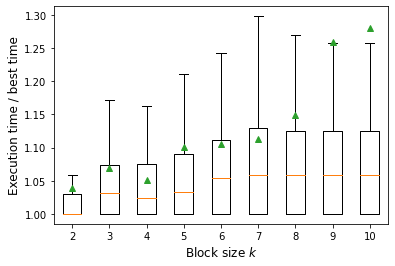

In [102]:
box_plot_k_comparison(data_100k_diff_k2)

In [103]:
k_scores100k2, data_100k_diff_k2 = k_comparison(data_100k_diff_k2)
k_scores100k2

,k,mean,median
0,2,1.038666,1.000000
1,3,1.069861,1.031764
2,4,1.051023,1.023472
3,5,1.100417,1.033151
4,6,1.105953,1.054788
5,7,1.113483,1.058761
6,8,1.149051,1.058761
7,9,1.258805,1.058761
8,10,1.280424,1.058761


#### 1M dataset


In [104]:
path = "./data/1M/no-server/different-k-comparison"
data_1M_diff_k2 = read_folder_csv(path)


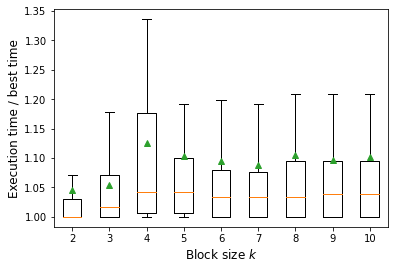

In [105]:
box_plot_k_comparison(data_1M_diff_k2)


In [106]:
k_scores1M2, data_1M_diff_k2 = k_comparison(data_1M_diff_k2)
k_scores1M2


,k,mean,median
0,2,1.045261,1.000000
1,3,1.053369,1.016764
2,4,1.124865,1.042917
3,5,1.102799,1.042902
4,6,1.095801,1.033617
5,7,1.087829,1.033617
6,8,1.105119,1.033617
7,9,1.096399,1.038325
8,10,1.102296,1.038325


#### 10M dataset


In [107]:
path = "./data/10M/no-server/different-k-comparison"
data_10M_diff_k2 = read_folder_csv(path)


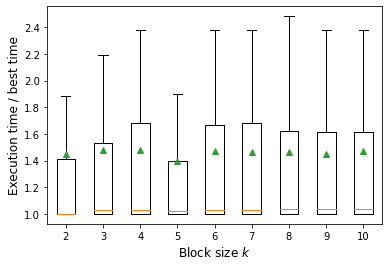

In [108]:
box_plot_k_comparison(data_10M_diff_k2)


In [109]:
k_scores10M2, data_10M_diff_k2 = k_comparison(data_10M_diff_k2)
k_scores10M2

# comparable with original crop research
# best k = 5!

,k,mean,median
0,2,1.449725,1.000000
1,3,1.477556,1.027623
2,4,1.478211,1.029957
3,5,1.398971,1.018961
4,6,1.475032,1.026849
5,7,1.464032,1.032568
6,8,1.463540,1.033261
7,9,1.446007,1.033261
8,10,1.471284,1.033261


In [110]:
# printForLatex(k_scores100k2)
# print()
# printForLatex(k_scores1M2)
# print()
# printForLatex(k_scores10M2)



### Server.js - CROP vs Comunica


In [111]:
def score_per_queryset(df):

    df_engine_set = df[['engine','set']].drop_duplicates()

    def mean_total_time(row):
        sett = row['set']
        engine = row['engine']

        df_query = df[(df['set'] == sett) & (df['engine'] == engine)]
        return df_query['totalTime'].mean()

    df_engine_set['total_time_mean'] = df.apply(mean_total_time, axis=1)

    return df_engine_set

def compare_results(df, engines):
    # engines = [{engine_name: <x>, display_name: <x>}, ..]

    df_per_set = score_per_queryset(df)

    # https://stackoverflow.com/questions/53182452/python-create-bar-chart-comparing-2-sets-of-data
    index = np.arange(len(df_per_set['set'].unique()))
    bar_width = 0.7 / len(engines)

    fig, ax = plt.subplots(figsize=(15, 6))
    ax.yaxis.grid(True)

    sets = df_per_set.sort_values(by='set')['set'].unique()

    for i, engine in enumerate(engines):
        mean_times = df_per_set[df_per_set['engine'] == engine['engine_name']]\
            .sort_values(by='set')['total_time_mean']
        ax.bar(index+i*bar_width, mean_times, bar_width, label=engine['display_name'], log=1)

    ax.set_xlabel('WatDiv query type')
    ax.set_ylabel('Runtime [ms]')
    # ax.set_title('Crime incidence by season, type')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(sets)
    ax.legend()

    plt.show()


#### 100k dataset

In [112]:
path = "./data/100k/ldf-server/crop-vs-comunica"

data_100k_comp = read_folder_csv(path)

data_100k_comp.head()

,engine,set,dataset,k,id,triples,results,calcTime,execTime,totalTime,error,timestamps
0,comunica,C2,100k,-1,0,10,0,NaN,134.9998,134.9998,NaN,NaN
1,crop-js-3,C2,100k,3,0,10,0,1.9942,382.7991,384.7933,NaN,NaN
2,crop-wasm-3,C2,100k,3,0,10,0,0.5764,385.9684,386.5448,NaN,NaN
3,comunica,S6,100k,-1,0,3,0,NaN,2.9754,2.9754,NaN,NaN
4,comunica,S6,100k,-1,1,3,0,NaN,2.2177,2.2177,NaN,NaN


In [113]:
df_engine_set100k = score_per_queryset(data_100k_comp)
df_engine_set100k

,engine,set,total_time_mean
0,comunica,C2,134.99980
1,crop-js-3,C2,384.79330
2,crop-wasm-3,C2,386.54480
3,comunica,S6,4.66832
8,crop-js-3,S6,1.72918
13,crop-wasm-3,S6,1.46594
18,comunica,L1,34.21628
23,crop-js-3,L1,60.97928
28,crop-wasm-3,L1,59.60916
33,comunica,S7,2.32246


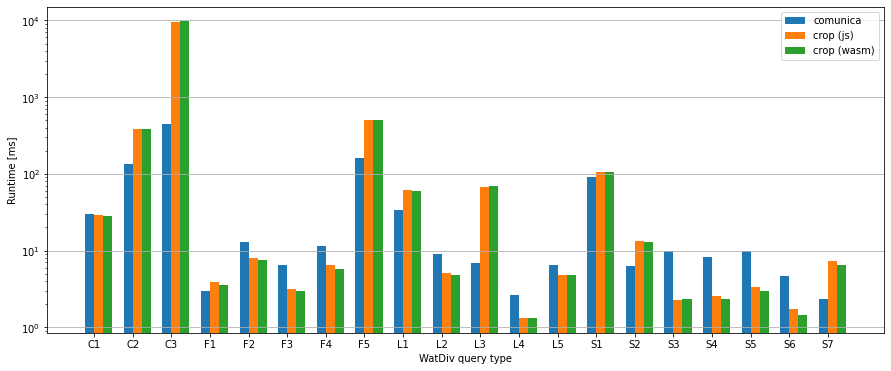

In [114]:
engines = [
    {'engine_name': 'comunica', 'display_name': 'comunica'},
    {'engine_name': 'crop-js-3', 'display_name': 'crop (js)'},
    {'engine_name': 'crop-wasm-3', 'display_name': 'crop (wasm)'}
]

compare_results(data_100k_comp, engines)

#### 1M dataset

In [115]:
path = "./data/1M/ldf-server/crop-vs-comunica"

data_1M_comp = read_folder_csv(path)

data_1M_comp.head()


,engine,set,dataset,k,id,triples,results,calcTime,execTime,totalTime,error,timestamps
0,comunica,C2,1M,-1,0,10,0,NaN,2166.991333,2166.991333,NaN,NaN
1,crop-wasm-2,C2,1M,2,0,10,0,0.380333,32527.908333,32528.288667,NaN,NaN
2,crop-wasm-100,C2,1M,100,0,10,0,9.063000,876733.017000,876742.080000,NaN,NaN
3,comunica,S6,1M,-1,0,3,0,NaN,20.340333,20.340333,NaN,NaN
4,comunica,S6,1M,-1,1,3,0,NaN,30.216667,30.216667,NaN,NaN


In [116]:
df_engine_set1M = score_per_queryset(data_1M_comp)
df_engine_set1M.head()

,engine,set,total_time_mean
0,comunica,C2,2166.991333
1,crop-wasm-2,C2,32528.288667
2,crop-wasm-100,C2,876742.080000
3,comunica,S6,82.143733
8,crop-wasm-2,S6,3.250067


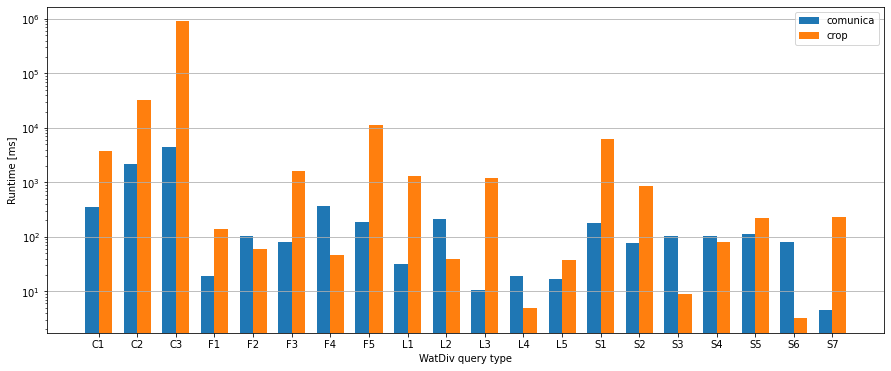

In [117]:
engines = [
    {'engine_name': 'comunica', 'display_name': 'comunica'},
    {'engine_name': 'crop-wasm-2', 'display_name': 'crop'},
    # {'engine_name': 'crop-wasm-100', 'display_name': 'worse crop'} # max k value for all queries
]

compare_results(data_1M_comp, engines)


#### 10M dataset

In [118]:
path = "./data/10M/ldf-server/crop-vs-comunica"

data_10M_comp = read_folder_csv(path)

data_10M_comp.head()


,engine,set,dataset,k,id,triples,results,calcTime,execTime,totalTime,error,timestamps
0,comunica,C2,10M,-1,0,10,0,NaN,22395.909667,22395.909667,NaN,NaN
1,comunica,S6,10M,-1,0,3,0,NaN,61.250000,61.250000,NaN,NaN
2,comunica,S6,10M,-1,1,3,0,NaN,63.467333,63.467333,NaN,NaN
3,comunica,S6,10M,-1,2,3,2,NaN,133.874333,133.874333,NaN,NaN
4,comunica,S6,10M,-1,3,3,0,NaN,30.138667,30.138667,NaN,NaN


In [119]:
df_engine_set10M = score_per_queryset(data_10M_comp)
df_engine_set10M

,engine,set,total_time_mean
0,comunica,C2,22395.909667
1,comunica,S6,61.029867
6,comunica,L1,352.303667
11,comunica,S7,1.311667
16,comunica,L3,11.607467
21,comunica,C3,101564.010000
22,comunica,F2,2277.976933
27,comunica,L2,1187.835333
32,comunica,F1,487.343400
37,comunica,S4,2666.076467


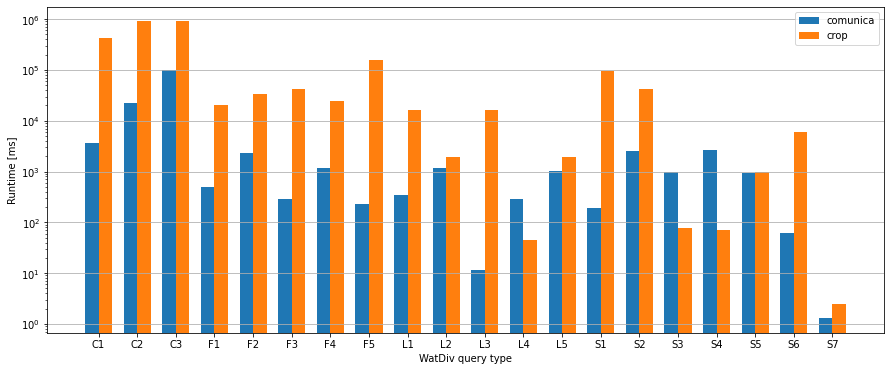

In [120]:
engines = [
    {'engine_name': 'comunica', 'display_name': 'comunica'},
    {'engine_name': 'crop-js-2', 'display_name': 'crop'}
]

compare_results(data_10M_comp, engines)

### No server.js (file hosted) - CROP vs Comunica

#### 100k dataset

In [121]:
path = "./data/100k/no-server/crop-vs-comunica"

data_100k_comp2 = read_folder_csv(path)

data_100k_comp2.head()

,engine,set,dataset,k,id,triples,results,calcTime,execTime,totalTime,error,timestamps
0,comunica,C2,100k,-1,0,10,0,NaN,406.8443,406.8443,NaN,NaN
1,crop-wasm-2,C2,100k,2,0,10,0,0.3091,68.5825,68.8916,NaN,NaN
2,comunica,S6,100k,-1,0,3,0,NaN,3.7734,3.7734,NaN,NaN
3,comunica,S6,100k,-1,1,3,0,NaN,2.4578,2.4578,NaN,NaN
4,comunica,S6,100k,-1,2,3,0,NaN,1.7779,1.7779,NaN,NaN


In [122]:
df_engine_set100k2 = score_per_queryset(data_100k_comp2)
df_engine_set100k2.head()

,engine,set,total_time_mean
0,comunica,C2,406.84430
1,crop-wasm-2,C2,68.89160
2,comunica,S6,2.79982
7,crop-wasm-2,S6,13.96292
12,comunica,L1,33.14414


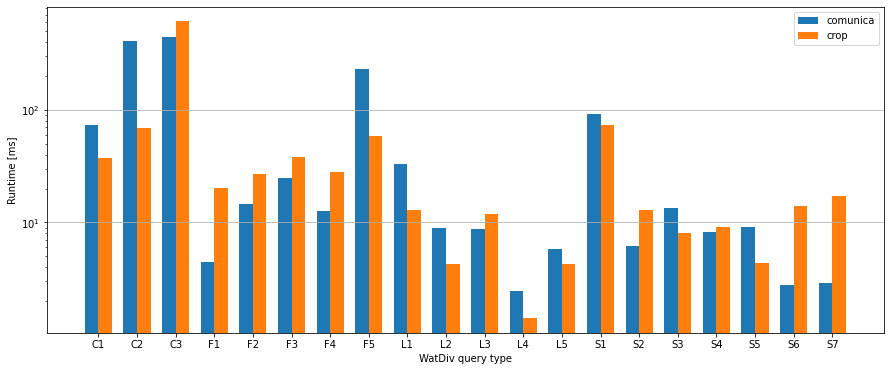

In [123]:
engines = [
    {'engine_name': 'comunica', 'display_name': 'comunica'},
    {'engine_name': 'crop-wasm-2', 'display_name': 'crop'}
]

compare_results(data_100k_comp2, engines)

#### 1M dataset

In [124]:
path = "./data/1M/no-server/crop-vs-comunica"

data_1M_comp2 = read_folder_csv(path)

data_1M_comp2.head()


,engine,set,dataset,k,id,triples,results,calcTime,execTime,totalTime,error,timestamps
0,comunica,C2,1M,-1,0,10,0,NaN,86134.475000,86134.475000,NaN,NaN
1,crop-wasm-2,C2,1M,2,0,10,0,0.358667,686.290667,686.649333,NaN,NaN
2,comunica,S6,1M,-1,0,3,0,NaN,30.102000,30.102000,NaN,NaN
3,comunica,S6,1M,-1,1,3,0,NaN,30.903667,30.903667,NaN,NaN
4,comunica,S6,1M,-1,2,3,0,NaN,17.404333,17.404333,NaN,NaN


In [125]:
df_engine_set1M2 = score_per_queryset(data_1M_comp2)
df_engine_set1M2.head()

,engine,set,total_time_mean
0,comunica,C2,86134.475000
1,crop-wasm-2,C2,686.649333
2,comunica,S6,26.953600
7,crop-wasm-2,S6,141.031533
12,comunica,L1,43.513133


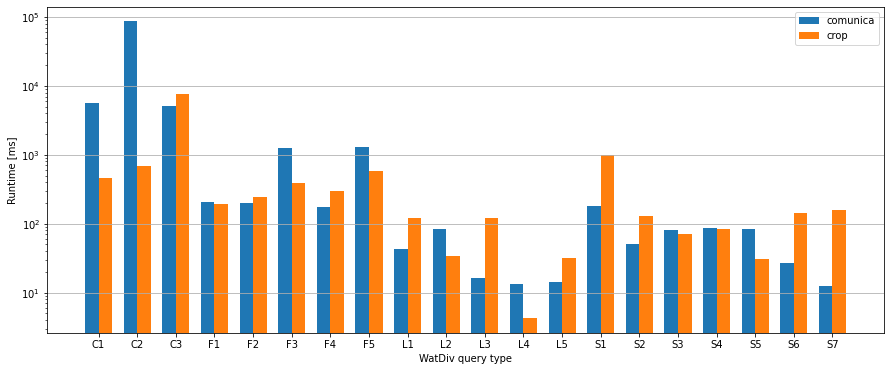

In [126]:
engines = [
    {'engine_name': 'comunica', 'display_name': 'comunica'},
    {'engine_name': 'crop-wasm-2', 'display_name': 'crop'}
]

compare_results(data_1M_comp2, engines)


#### 10M dataset

In [127]:
path = "./data/10M/no-server/crop-vs-comunica"

data_10M_comp2 = read_folder_csv(path)

data_10M_comp2.head()


,engine,set,dataset,k,id,triples,results,calcTime,execTime,totalTime,error,timestamps
0,comunica,C2,10M,-1,-1,-1,-1,-1.000,900000.000000,900000.000000,reached timeout,NaN
1,crop-wasm-5,C2,10M,5,0,10,0,2.228,16697.852000,16700.080000,NaN,NaN
2,comunica,S6,10M,-1,0,3,0,NaN,280.525000,280.525000,NaN,NaN
3,comunica,S6,10M,-1,1,3,0,NaN,234.433667,234.433667,NaN,NaN
4,comunica,S6,10M,-1,2,3,2,NaN,240.097667,240.097667,NaN,NaN


In [128]:
df_engine_set10M2 = score_per_queryset(data_10M_comp2)
df_engine_set10M2.head()

,engine,set,total_time_mean
0,comunica,C2,900000.000000
1,crop-wasm-5,C2,16700.080000
2,comunica,S6,213.761067
7,crop-wasm-5,S6,3393.657000
12,comunica,L1,263.926200


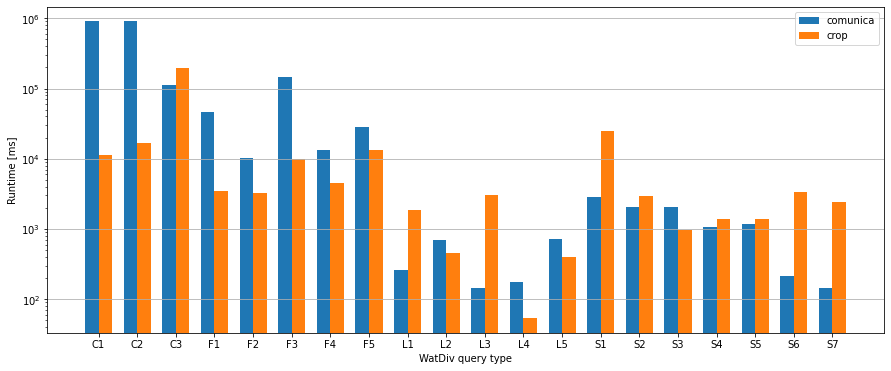

In [129]:
engines = [
    {'engine_name': 'comunica', 'display_name': 'comunica'},
    {'engine_name': 'crop-wasm-5', 'display_name': 'crop'}
]

compare_results(data_10M_comp2, engines)


In [130]:
def print_comparison(results_df, source_df):
    df = results_df.copy()

    def find_error(row):
        engine = row['engine']
        set = row['set']

        df_set = source_df[(source_df['engine'] == engine) & (source_df['set'] == set)]
        df_set = df_set[df_set['error'] != '']
        df_set = df_set[df_set['error'].notnull()]


        if df_set.empty:
            return ''
        else:
            return df_set.iloc[0]['error']

    df['error'] = df.apply(find_error, axis=1)
    printForLatex(df)

# print_comparison(df_engine_set100k, data_100k_comp)
# print("")
# print_comparison(df_engine_set1M, data_1M_comp)
# print("")
# print_comparison(df_engine_set10M, data_10M_comp)
#
# print("")
#
# print_comparison(df_engine_set100k2, data_100k_comp2)
# print("")
# print_comparison(df_engine_set1M2, data_1M_comp2)
# print("")
# print_comparison(df_engine_set10M2, data_10M_comp2)

Strange results in server.js comparison, some queries take too long

Caused by slower NestedLoop operator in Comunica / more advanced NestedLoop (bind?) in nLDE (xnjoin)

Compare against comunica with only nested loop join & hash join as one of the measurres to verify the algorithm effectiveness.
Only 100k & 1M, 10M times out


### Server.js - CROP vs Comunica vs Comunica (only NLJ & HSJ)

#### 100k dataset

In [131]:
path = "./data/100k/ldf-server/no-bindjoin"

data_100k_comp3 = read_folder_csv(path)

data_100k_comp3.head()

,engine,set,dataset,k,id,triples,results,calcTime,execTime,totalTime,error,timestamps
0,comunica,C2,100k,-1,0,10,0,NaN,137.647000,137.647000,NaN,NaN
1,comunica-flat,C2,100k,-1,0,10,0,NaN,181187.777000,181187.777000,NaN,NaN
2,crop-wasm-3,C2,100k,3,0,10,0,0.666333,768.429667,769.096000,NaN,NaN
3,comunica,S6,100k,-1,0,3,0,NaN,7.991000,7.991000,NaN,NaN
4,comunica,S6,100k,-1,1,3,0,NaN,4.694333,4.694333,NaN,NaN


In [132]:
df_engine_set100k3 = score_per_queryset(data_100k_comp3)
df_engine_set100k3.head()

,engine,set,total_time_mean
0,comunica,C2,137.6470
1,comunica-flat,C2,181187.7770
2,crop-wasm-3,C2,769.0960
3,comunica,S6,4.3660
8,comunica-flat,S6,31.9918


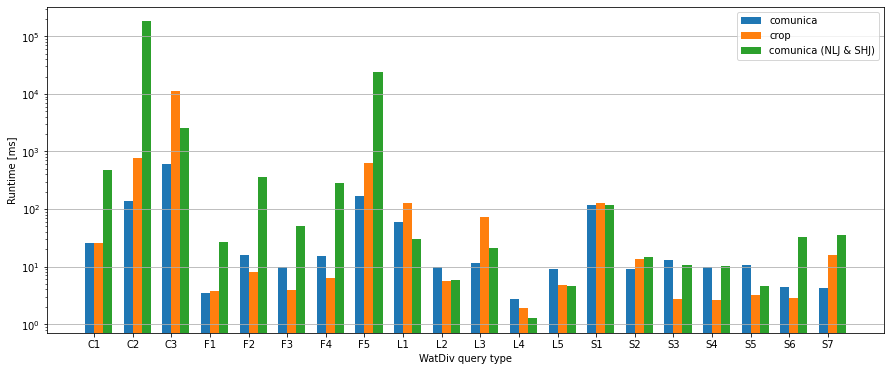

In [133]:
engines = [
    {'engine_name': 'comunica', 'display_name': 'comunica'},
    {'engine_name': 'crop-wasm-3', 'display_name': 'crop'},
    {'engine_name': 'comunica-flat', 'display_name': 'comunica (NLJ & SHJ)'}
]

compare_results(data_100k_comp3, engines)

#### 1M dataset

In [134]:
path = "./data/1M/ldf-server/no-bindjoin"

data_1M_comp3 = read_folder_csv(path)

data_1M_comp3.head()

,engine,set,dataset,k,id,triples,results,calcTime,execTime,totalTime,error,timestamps
0,comunica,C2,1M,-1,0,10,0,NaN,2139.026667,2139.026667,NaN,NaN
1,comunica-flat,C2,1M,-1,-1,-1,-1,-1.000,900000.000000,900000.000000,FetchError,NaN
2,crop-wasm-2,C2,1M,2,0,10,0,0.415,33083.475000,33083.890000,NaN,NaN
3,comunica,S6,1M,-1,0,3,0,NaN,18.272667,18.272667,NaN,NaN
4,comunica,S6,1M,-1,1,3,0,NaN,31.473333,31.473333,NaN,NaN


In [135]:
df_engine_set1Mk3 = score_per_queryset(data_1M_comp3)
df_engine_set1Mk3.head()

,engine,set,total_time_mean
0,comunica,C2,2139.026667
1,comunica-flat,C2,900000.000000
2,crop-wasm-2,C2,33083.890000
3,comunica,S6,22.243133
8,comunica-flat,S6,655.263800


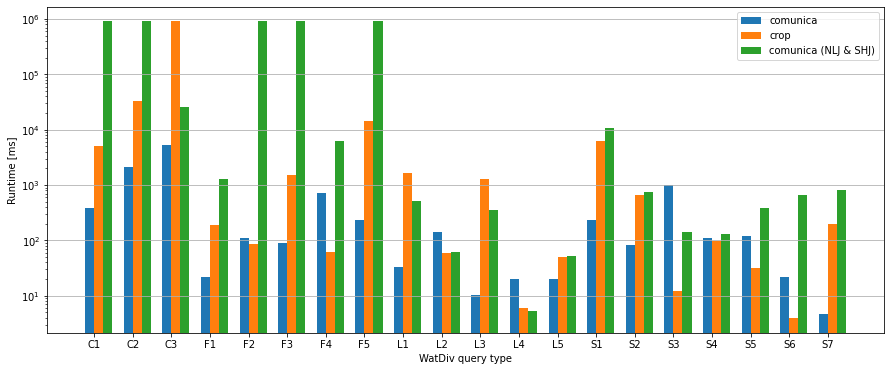

In [136]:
engines = [
    {'engine_name': 'comunica', 'display_name': 'comunica'},
    {'engine_name': 'crop-wasm-2', 'display_name': 'crop'},
    {'engine_name': 'comunica-flat', 'display_name': 'comunica (NLJ & SHJ)'}
]

compare_results(data_1M_comp3, engines)